In [2]:
import numpy as np

# Pyomo

## Import

In [3]:
import pyomo
import pyomo.environ as pyo

## Create Pyomo Model

### Instantiate Model

In [7]:
opt_model = pyo.ConcreteModel()

### Create Sets
These will be used to index constraints and variables

In [8]:
N = 48 #MPC HORIZON
NUMBER_OF_UNITS = 1


# Time Steps
opt_model.mpc_horizon = pyo.Set(initialize=range(0, N)) # set
# Units
opt_model.units_set = pyo.Set(initialize=range(NUMBER_OF_UNITS))

### Define Parameters
These are constant values and can be indexed over the defined sets

In [9]:
# Initialize Setpoint for t=0 to t=N
def setpoint_init(model, i, j): # functions always contain these input arguments: (model, set1_index, set2_index, etc..)
    return np.ones((N))[i]*21 # Assume setpoint is always 21 C

opt_model.setpoints = pyo.Param(opt_model.units_set, opt_model.mpc_horizon, # Index parameters over the sets [units, timestep]
                                initialize=setpoint_init, # Defines the values
                                mutable=True # Says it can be changed in the future (optional)
                               )

# Initialize Outdoor Temp for t=0 to t=N
def outdoor_temp_init(model, i, j): # functions always contain these input arguments: (model, set1_index, set2_index, etc..)
        return 21#outdoor_temp[j] # User defined weather object containing weather data

opt_model.outdoor_temp = pyo.Param(opt_model.units_set, opt_model.mpc_horizon, # Index parameters over the sets [units, timestep]
                                   initialize=outdoor_temp_init,
                                   mutable=True)

Tip on debugging/printing parameter values:

In [10]:
# This only prints the indexes of the parameters
print(list(opt_model.outdoor_temp))

# This calls and prints the actual parameter values for each index
for i in range(1,N):
    print(f'{pyo.value(opt_model.outdoor_temp[0, i]):.2f}', end=" ")

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47)]
21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 21.00 

### Define Variables

In [11]:
# HP Control Variable
def u_hp_binary_init(model, i, j): # functions always contain these input arguments: (model, set1_index, set2_index, etc..)
    return 1
    
opt_model.u_hp_binary = pyo.Var(opt_model.units_set, opt_model.mpc_horizon, 
                                domain=pyo.Binary, #pyo.Reals,pyo.NonNegativeReals, etc.
                                initialize=u_hp_binary_init # This can be used for a warm start
                               )

# Indoor Temperature Variable
opt_model.indoor_temp = pyo.Var(opt_model.units_set, 
                                opt_model.mpc_horizon, 
                                domain=pyo.Reals,
                                bounds=(10, 35))
opt_model.mass_temp = pyo.Var(opt_model.units_set, 
                              opt_model.mpc_horizon, 
                              domain=pyo.Reals,
                                bounds=(10, 35))
# etc.

### Define Constraints

In [12]:
# Indoor Temperature Constraint
comfort_level = 1
def upper_temp_constraint(model, i, j): # constraints always contain these input arguments: (model, set1_index, set2_index, etc..)
    return model.indoor_temp[i, j]  <= model.setpoints[i, j] + comfort_level

opt_model.upper_temp_constraint = pyo.Constraint(opt_model.units_set, opt_model.mpc_horizon, # Sets to index over
                                                 rule=upper_temp_constraint # Function that defines the constraint
                                                )

### Define Objective Function

In [14]:
def obj(model): # Always pass in model. No need to index objective function since there is only one objective
    """
    Objective function for an aggregate of units

    :param opt_model:
    :return: cost: objective value
    """
    cost = 0
    for i in model.units_set:
        for j in model.mpc_horizon:
            cost = cost + model.u_hp_binary[i,j]
    return cost

opt_model.obj = pyo.Objective(rule=obj, sense=pyo.maximize)


### Solve

In [15]:
# Create your solver. This locates the executable used to solve the problem
solver = pyo.SolverFactory('cplex',
                        # executable=r'C:\Program Files\IBM\ILOG\CPLEX_Studio129\cplex\bin\x64_win64\cplex.exe'
                        )

# Solve the model
results = solver.solve(opt_model, 
                       tee=True, #Show log 
                       warmstart=True,
                       options={ # Options can be found on cplex website
                              'timelimit': 300,
                              # '1067': 36, #threads
                              #'mipgap': .1,
                              # '2010': .001 #optimality gap
                              }, 
                       keepfiles=True # Required if multiprocessing
                      )

# Just in case it's infeasible
if results.solver.termination_condition == pyomo.opt.TerminationCondition.infeasible:
    for i in opt_model.units_set:
        u_hp[i, 0] = pyo.value(opt_model.u_hp_binary[i, 0]) # If infeasible, initialize a control value
    print('INFEASIBLE!!!!')


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.9.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2019.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\Zach\AppData\Local\Temp\tmp453h2h42.cplex.log' open.
CPLEX> New value for time limit in seconds: 300
CPLEX> Problem 'C:\Users\Zach\AppData\Local\Temp\tmpfkooqbih.pyomo.lp' read.
Read time = 0.00 sec. (0.00 ticks)
CPLEX> MIP start file 'C:\Users\Zach\AppData\Local\Temp\tmpm713ct7n.cplex.mst' read.
CPLEX> Problem name         : C:\Users\Zach\AppData\Local\Temp\tmpfkooqbih.pyomo.lp
Objective sense      : Maximize
Variables            :      97  [Nneg: 1,  Box: 48,  Binary: 48]
Objective nonzeros   :      48
Linear constraints   :      49  [Less: 48,  Equal: 1]
  Nonzeros           :     

### Get Control Values

In [16]:
# Obtaining the decision variables from the model:
u_hp = np.zeros((len(opt_model.units_set), len(opt_model.mpc_horizon)))

for i in opt_model.units_set:
    for j in opt_model.mpc_horizon:
        u_hp[i, j] = pyo.value(opt_model.u_hp_binary[i, j])
        print(u_hp[i, j], end=" ")


1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

# Sklearn

Powerful high-level package for machine-learning, data science, etc.

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

## Linear Regression

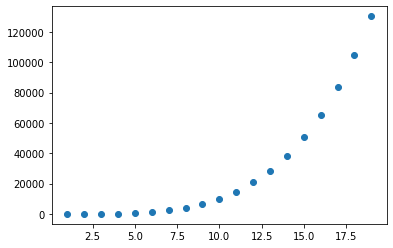

In [13]:
X = np.arange(1, 20, 1).reshape(-1, 1)
Y = (X[:,0]**4 + 4 + np.random.rand(len(X))*50-25).reshape(-1, 1) 

f, ax1 = plt.subplots(1, 1)
ax1.scatter(X[:, 0], Y[:, 0])

### Linear Regression

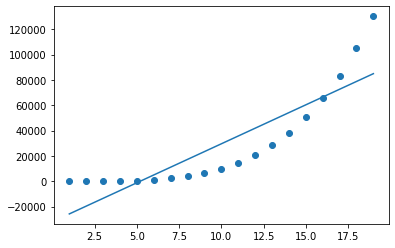

In [14]:
# L
import sklearn.linear_model

model = sklearn.linear_model.LinearRegression()
model = model.fit(X, Y)

Y_pred = model.predict(X)
f, ax1 = plt.subplots(1, 1)
ax1.scatter(X[:, 0], Y[:, 0])
ax1.plot(X[:, 0], Y_pred[:, 0])

### Polynomial Line

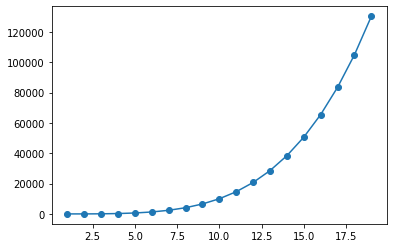

In [15]:
poly = sklearn.preprocessing.PolynomialFeatures(degree=4)
poly_X = poly.fit_transform(X)

poly_model = sklearn.linear_model.LinearRegression()
poly_model = model.fit(poly_X, Y)


Y_pred = poly_model.predict(poly_X)
f, ax1 = plt.subplots(1, 1)
ax1.scatter(X[:, 0], Y[:, 0])
ax1.plot(X[:, 0], Y_pred[:, 0])

### Random Forest

C:\Users\Zach\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


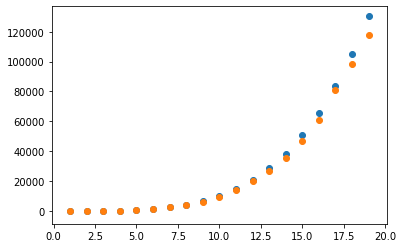

In [16]:
import sklearn.ensemble
rf_model = sklearn.ensemble.RandomForestRegressor(random_state=0, 
                                                  min_samples_leaf=1,
                                                  n_estimators=50
                                                  )
result = rf_model.fit(X, Y)

Y_pred = rf_model.predict(X)

f, ax1 = plt.subplots(1, 1)
ax1.scatter(X[:, 0], Y[:, 0])
ax1.scatter(X[:, 0], Y_pred)

## Scaling Data

In [17]:
scaler = sklearn.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.64316767],
       [-1.46059349],
       [-1.2780193 ],
       [-1.09544512],
       [-0.91287093],
       [-0.73029674],
       [-0.54772256],
       [-0.36514837],
       [-0.18257419],
       [ 0.        ],
       [ 0.18257419],
       [ 0.36514837],
       [ 0.54772256],
       [ 0.73029674],
       [ 0.91287093],
       [ 1.09544512],
       [ 1.2780193 ],
       [ 1.46059349],
       [ 1.64316767]])

In [18]:
# To Scale Validation Data
X_val = np.arange(15, 20).reshape(-1, 1)
X_val_scaled = scaler.transform(X_val)
X_val_scaled

array([[0.91287093],
       [1.09544512],
       [1.2780193 ],
       [1.46059349],
       [1.64316767]])

## Working With Time Series Data

In [19]:
import pickle
outdoor_temp = pickle.load(open(f'outdoor_temp.sav', 'rb'))
weather_df = pickle.load(open(f'weather_df.sav', 'rb'))
data = weather_df
data

,GHI_(kW/m2),Dewpoint_(C),Wind_Speed_(m/s),Relative Humidity,Outdoor_Temp_(C),Pressure_(mbar)
timestamp,,,,,,
2018-02-23 00:00:00,0.0,-4.100000,0.6,99.030000,-4.000000,982.000000
2018-02-23 00:05:00,0.0,-4.100000,0.6,99.155000,-4.016667,982.000000
2018-02-23 00:10:00,0.0,-4.100000,0.6,99.280000,-4.033333,982.000000
2018-02-23 00:15:00,0.0,-4.100000,0.6,99.405000,-4.050000,982.000000
2018-02-23 00:20:00,0.0,-4.100000,0.6,99.530000,-4.066667,982.000000
2018-02-23 00:25:00,0.0,-4.100000,0.6,99.655000,-4.083333,982.000000
2018-02-23 00:30:00,0.0,-4.100000,0.6,99.780000,-4.100000,982.000000
2018-02-23 00:35:00,0.0,-4.133333,0.6,99.718333,-4.116667,982.000000
2018-02-23 00:40:00,0.0,-4.166667,0.6,99.656667,-4.133333,982.000000


### Puts data into Autoregressive Form

In [20]:
import pandas as pd
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,categories=False,auxcats=False):


    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list, df, or NumPy array.
        n_in: (int) Number of lag observations as input (X).
        n_out: (int) Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        categories: (list) Categories to keep
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """

    df = pd.DataFrame(data)
    if categories != False:
        df = df[categories]
    n_vars = 1 if type(data) is list else df.shape[1]
    cols, names = list(), list()
    # past sequence (t, t-1, ... t-n)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        if i == 0:
            names += [(df.columns[j] + '(t)') for j in range(n_vars)]
        else:
            names += [(df.columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        names += [(df.columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg, n_vars

In [21]:
lagging_steps = 48
forward_steps = 48

data_sup, n_vars = series_to_supervised(data, lagging_steps, forward_steps, 
                                                   categories=['GHI_(kW/m2)', 
                                                               'Dewpoint_(C)', 
                                                               'Wind_Speed_(m/s)', 
                                                               'Relative Humidity', 
                                                               'Outdoor_Temp_(C)', 
                                                               'Pressure_(mbar)' 
                                                              ]
                                                  )
labelcols=[]
for i in range(forward_steps):
    labelcols.append(f'Outdoor_Temp_(C)(t+{i})')
dropcols = labelcols.copy()

labels = data_sup[labelcols]
features = data_sup.drop(columns=dropcols, errors='ignore').dropna()

In [22]:
features

,GHI_(kW/m2)(t-48),Dewpoint_(C)(t-48),Wind_Speed_(m/s)(t-48),Relative Humidity(t-48),Outdoor_Temp_(C)(t-48),Pressure_(mbar)(t-48),GHI_(kW/m2)(t-47),Dewpoint_(C)(t-47),Wind_Speed_(m/s)(t-47),Relative Humidity(t-47),...,GHI_(kW/m2)(t+46),Dewpoint_(C)(t+46),Wind_Speed_(m/s)(t+46),Relative Humidity(t+46),Pressure_(mbar)(t+46),GHI_(kW/m2)(t+47),Dewpoint_(C)(t+47),Wind_Speed_(m/s)(t+47),Relative Humidity(t+47),Pressure_(mbar)(t+47)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-23 04:00:00,0.000000,-4.100000,0.6,99.030000,-4.000000,982.000000,0.000000,-4.100000,0.6,99.155000,...,0.079667,-2.000000,1.366667,93.033333,978.000000,0.088333,-1.900000,1.383333,93.381667,978.000000
2018-02-23 04:05:00,0.000000,-4.100000,0.6,99.155000,-4.016667,982.000000,0.000000,-4.100000,0.6,99.280000,...,0.088333,-1.900000,1.383333,93.381667,978.000000,0.097000,-1.800000,1.400000,93.730000,978.000000
2018-02-23 04:10:00,0.000000,-4.100000,0.6,99.280000,-4.033333,982.000000,0.000000,-4.100000,0.6,99.405000,...,0.097000,-1.800000,1.400000,93.730000,978.000000,0.103833,-1.800000,1.416667,93.266667,977.833333
2018-02-23 04:15:00,0.000000,-4.100000,0.6,99.405000,-4.050000,982.000000,0.000000,-4.100000,0.6,99.530000,...,0.103833,-1.800000,1.416667,93.266667,977.833333,0.110667,-1.800000,1.433333,92.803333,977.666667
2018-02-23 04:20:00,0.000000,-4.100000,0.6,99.530000,-4.066667,982.000000,0.000000,-4.100000,0.6,99.655000,...,0.110667,-1.800000,1.433333,92.803333,977.666667,0.117500,-1.800000,1.450000,92.340000,977.500000
2018-02-23 04:25:00,0.000000,-4.100000,0.6,99.655000,-4.083333,982.000000,0.000000,-4.100000,0.6,99.780000,...,0.117500,-1.800000,1.450000,92.340000,977.500000,0.124333,-1.800000,1.466667,91.876667,977.333333
2018-02-23 04:30:00,0.000000,-4.100000,0.6,99.780000,-4.100000,982.000000,0.000000,-4.133333,0.6,99.718333,...,0.124333,-1.800000,1.466667,91.876667,977.333333,0.131167,-1.800000,1.483333,91.413333,977.166667
2018-02-23 04:35:00,0.000000,-4.133333,0.6,99.718333,-4.116667,982.000000,0.000000,-4.166667,0.6,99.656667,...,0.131167,-1.800000,1.483333,91.413333,977.166667,0.138000,-1.800000,1.500000,90.950000,977.000000
2018-02-23 04:40:00,0.000000,-4.166667,0.6,99.656667,-4.133333,982.000000,0.000000,-4.200000,0.6,99.595000,...,0.138000,-1.800000,1.500000,90.950000,977.000000,0.141000,-1.700000,1.516667,91.133333,977.000000


In [23]:
labels

,Outdoor_Temp_(C)(t+0),Outdoor_Temp_(C)(t+1),Outdoor_Temp_(C)(t+2),Outdoor_Temp_(C)(t+3),Outdoor_Temp_(C)(t+4),Outdoor_Temp_(C)(t+5),Outdoor_Temp_(C)(t+6),Outdoor_Temp_(C)(t+7),Outdoor_Temp_(C)(t+8),Outdoor_Temp_(C)(t+9),...,Outdoor_Temp_(C)(t+38),Outdoor_Temp_(C)(t+39),Outdoor_Temp_(C)(t+40),Outdoor_Temp_(C)(t+41),Outdoor_Temp_(C)(t+42),Outdoor_Temp_(C)(t+43),Outdoor_Temp_(C)(t+44),Outdoor_Temp_(C)(t+45),Outdoor_Temp_(C)(t+46),Outdoor_Temp_(C)(t+47)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-23 04:00:00,-3.500000,-3.466667,-3.433333,-3.400000,-3.366667,-3.333333,-3.300000,-3.266667,-3.233333,-3.200000,...,-1.466667,-1.400000,-1.333333,-1.266667,-1.200000,-1.150000,-1.100000,-1.050000,-1.000000,-0.950000
2018-02-23 04:05:00,-3.466667,-3.433333,-3.400000,-3.366667,-3.333333,-3.300000,-3.266667,-3.233333,-3.200000,-3.166667,...,-1.400000,-1.333333,-1.266667,-1.200000,-1.150000,-1.100000,-1.050000,-1.000000,-0.950000,-0.900000
2018-02-23 04:10:00,-3.433333,-3.400000,-3.366667,-3.333333,-3.300000,-3.266667,-3.233333,-3.200000,-3.166667,-3.133333,...,-1.333333,-1.266667,-1.200000,-1.150000,-1.100000,-1.050000,-1.000000,-0.950000,-0.900000,-0.833333
2018-02-23 04:15:00,-3.400000,-3.366667,-3.333333,-3.300000,-3.266667,-3.233333,-3.200000,-3.166667,-3.133333,-3.100000,...,-1.266667,-1.200000,-1.150000,-1.100000,-1.050000,-1.000000,-0.950000,-0.900000,-0.833333,-0.766667
2018-02-23 04:20:00,-3.366667,-3.333333,-3.300000,-3.266667,-3.233333,-3.200000,-3.166667,-3.133333,-3.100000,-3.050000,...,-1.200000,-1.150000,-1.100000,-1.050000,-1.000000,-0.950000,-0.900000,-0.833333,-0.766667,-0.700000
2018-02-23 04:25:00,-3.333333,-3.300000,-3.266667,-3.233333,-3.200000,-3.166667,-3.133333,-3.100000,-3.050000,-3.000000,...,-1.150000,-1.100000,-1.050000,-1.000000,-0.950000,-0.900000,-0.833333,-0.766667,-0.700000,-0.633333
2018-02-23 04:30:00,-3.300000,-3.266667,-3.233333,-3.200000,-3.166667,-3.133333,-3.100000,-3.050000,-3.000000,-2.950000,...,-1.100000,-1.050000,-1.000000,-0.950000,-0.900000,-0.833333,-0.766667,-0.700000,-0.633333,-0.566667
2018-02-23 04:35:00,-3.266667,-3.233333,-3.200000,-3.166667,-3.133333,-3.100000,-3.050000,-3.000000,-2.950000,-2.900000,...,-1.050000,-1.000000,-0.950000,-0.900000,-0.833333,-0.766667,-0.700000,-0.633333,-0.566667,-0.500000
2018-02-23 04:40:00,-3.233333,-3.200000,-3.166667,-3.133333,-3.100000,-3.050000,-3.000000,-2.950000,-2.900000,-2.850000,...,-1.000000,-0.950000,-0.900000,-0.833333,-0.766667,-0.700000,-0.633333,-0.566667,-0.500000,-0.433333


## Train Model

In [24]:
temp_model = sklearn.linear_model.LinearRegression()
temp_model = temp_model.fit(features.iloc[:-100, :], labels.iloc[:-100, :])
temp_preds = temp_model.predict(features.iloc[-100:, :])

Text(0.5, 0, 'Time')

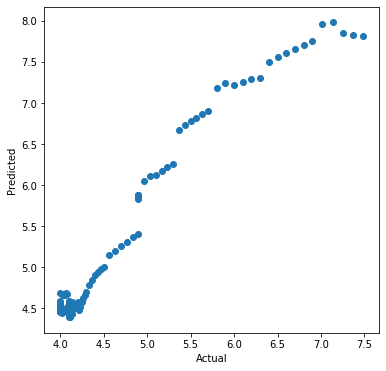

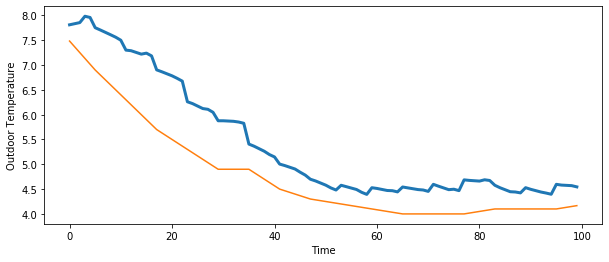

In [25]:
f, ax1 = plt.subplots(1, 1, figsize=(6, 6))
forecast_step = 46
ax1.scatter(labels.iloc[-100:, forecast_step], temp_preds[:, forecast_step])
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
f, ax2 = plt.subplots(1, 1, figsize=(10, 4))
ax2.plot(range(100), temp_preds[:, forecast_step], linewidth=3)
ax2.plot(range(100),labels.iloc[-100:, forecast_step])
ax2.set_ylabel('Outdoor Temperature')
ax2.set_xlabel('Time')